# Data Science 2
## Numerical analysis - Numerical differentiation

The following material is partly covered in Section 15 - *Floating Point Arithmetic: Issues and Limitations* of the [Python documentation](https://docs.python.org/3/tutorial/floatingpoint.html) and Chapter 5 - *Numerical Differentiation* of the book *Numerical methods in engineering with Python 3* by Jaan Kiusalaas (see BlackBoard).

### Introduction

Numerical differentiation deals with the following problem: We are given the function $y = f(x)$ and wish to obtain one of its derivatives at the point $x = x_k$. The term "given" means that we either have an algorithm for computing the function, or we possess a set of discrete datapoints $(x_i, y_i)$ for $i = 0,1,...,n$. In either case, we have access to a finite number of $(x, y)$ data pairs from which to compute the derivative.

Numerical differentiation is not a particularly accurate process. It suffers from a conflict between roundoff errors (caused by limited machine precision) and errors inherent in interpolation. For this reason, a derivative of a function can never be computed with the same precision as the function itself.

### Intermezzo: Floating Point Arithmetic

We assume that you are familiar with [binary](https://en.wikipedia.org/wiki/Binary_number) (and [hexadecimal](https://en.wikipedia.org/wiki/Hexadecimal)) representations of integer numbers (see for example these [short](https://www.youtube.com/watch?v=LpuPe81bc2w), [medium](https://www.youtube.com/watch?v=kTcpd4ef2lU), and [long](https://www.youtube.com/watch?v=vpjhJJQLPq4) video's, or this [series](https://www.youtube.com/watch?v=0qjEkh3P9RE&list=PL726AB973C6E39758) of video's).

Floating-point numbers are represented in computer hardware as base 2 (binary) fractions. For example, the *decimal* fraction 0.375 has value $\frac{3}{10} + \frac{7}{100} + \frac{5}{1000}$. In the same way the *binary* fraction 0.011 has value $\frac{0}{2} + \frac{1}{4} + \frac{1}{8}$. These two fractions have identical values ($\frac{3}{8} = 0.375$), the only real difference being that the first is written in base 10 fractional notation, and the second in base 2.

Unfortunately, most decimal fractions cannot be represented exactly as binary fractions. A consequence is that, in general, the decimal floating-point numbers you enter are only approximated by the binary floating-point numbers actually stored in the machine. For example, no matter how many base 2 digits you're willing to use, the decimal value 0.1 cannot be represented exactly as a base 2 fraction. In base 2, $\frac{1}{10}$ is the infinitely repeating fraction 0.00011001100110011001.. Stop at any finite number of bits, and you get an approximation. This is analogous to how in base 10 some other fractions cannot exactly be represented using a finite number of decimals, like $\frac{1}{7} = 0.142857142857..$.

This may have strange consequences. For example, since 0.1 is not exactly $\frac{1}{10}$, summing three values of 0.1 may not yield exactly 0.3.

In [2]:
x = 0.1
x + x + x == 0.3

False

On most machines today, floats are approximated using a binary fraction with a sign, an integer numerator, and a denominator that is a power of two. Almost all machines today use [IEEE-754](https://en.wikipedia.org/wiki/IEEE_754-1985) floating point arithmetic. Multiple types of floating point numbers are defined that differ in their precision. A common one is the 64-bit float that maps to IEEE-754 [double precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format). On input the computer strives to convert 0.1 to the closest fraction it can of the form $\frac{J}{2^N}$, where $J$ is an integer. In the case of 1/10, the binary fraction is $\frac{3602879701896397}{2^{55}}$ which is close to but not exactly equal to the true value of 1/10. Python provides tools that may help on those rare occasions when you really do want to know the exact value of a float. The `float.as_integer_ratio()` method expresses the value of a float as a fraction:

In [3]:
numerator, denominator = x.as_integer_ratio()
print(numerator, denominator)

3602879701896397 36028797018963968


In [4]:
numerator / denominator == x

True

In [5]:
#x = 1/7
num, den = x.as_integer_ratio()
print(num, den)
num / den == x

3602879701896397 36028797018963968


True

The `hex()` method expresses a float in hexadecimal (base 16), again giving the exact value stored by your computer.

In [6]:
print(x.hex())

0x1.999999999999ap-4


When converted from hexadecimal to binary, we would obtain `'0b1.1001100110011001100110011001100110011001100110011010p-4'`, which corresponds exactly with the (rounded) binary expansion given earlier. The `p` indicates binary scientific notation (similar to te `e` in base 10, like in `0.1 == 1e-1`).

We can access the internal binary representation directly using the following bit of code magic.

In [7]:
import struct
bits = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', x))
print(bits)

0011111110111001100110011001100110011001100110011001100110011010


A double-precision floating point value is encoded in 8 bytes. The 64 bits of this bit-representation can be dissected into three parts:

* 1 sign bit: `0` (for positive numbers, or `1` for negative numbers)

* 11 exponent bits: `01111111011` (for a biased exponent of 1019)

* 52 mantissa bits: `1001100110011001100110011001100110011001100110011010`

This generally translates into a value

$$
(-1)^\text{sign} \cdot (1.\text{mantissa})_\text{b} \times 2^{\text{exponent}-1023}
$$

Note that in binary, the first digit in scientific notation must always be a 1, so we do not need to encode that explicitly and simply prepend it before the decimal point before the mantissa. In the given case of 0.1, this becomes $(-1)^0 \cdot (1.1001100110011001100110011001100110011001100110011010)_b \times 2^{-4}$ which approximately equals 0.1.

**Exercise 1**

Determine the bit-representations of the following numbers and verify that you understand how these relate to the value of the number itself.

* `1.0`
* `1.5`
* `2.0`
* `-2.0`
* `-1.3333333333333333`
* `3.1415926535897932`
* `1.0000000000000002`
* `1.0000000000000001`

Also try the below "special" numbers.

* `0.0`
* `-0.0`
* `float('inf')`
* `float('-inf')`
* `float('nan')`

In [8]:
x = 1.5
num, den = x.as_integer_ratio()
print(num, den)
print(num / den == x)
print(x.hex())
bits = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', x))
print(bits)

3 2
True
0x1.8000000000000p+0
0011111111111000000000000000000000000000000000000000000000000000


In [9]:
import numpy as np
# to verify: https://www.h-schmidt.net/FloatConverter/IEEE754de.html
# explanations: https://de.wikipedia.org/wiki/IEEE_754
## single pecision
bit_len = 32-8-1+1 # mantiassa bit which is discarded is here added for double precis
rexpon_bias = 127 # entspricht 2^7 for double precision its 2^11
#----------------------------------------

#mantisse = 8
sign = 0
number = 1.3333

if number >= 0:
    sign = 0
else:
    sign = 1
number = np.abs(number)
# vor dem komma
pre_deci = number // 1

# nach dem komma
post_deci = number % 1

# special cases
if number == np.abs(0.0):
    rexpon_bias=0
elif number == np.inf:
    rexpon_bias = 255 # entpricht 2^8 exponentlänge

else:
    # calculate the binary repesentation for pre_deci
    floor = 0
    remainder = []
    while True:
        floor = pre_deci // 2
        remainder.append(int(pre_deci % 2))
        pre_deci = floor
        if pre_deci == 0:
            break

    remainder = remainder[::-1]
    print(remainder)

    dec_p = len(remainder)

    bin_list = np.zeros((bit_len), dtype = 'int')
    exponents = np.arange(bit_len, 0., -1)
    exponents = exponents - bit_len + dec_p -1.
    exponents = 2 ** exponents
    print(exponents)
    print(bin_list)

    for i in range(0, bit_len):

        bin_list[i] = 1
        if (exponents * bin_list).sum() > number:
            bin_list[i] = 0
        print(bin_list, (exponents * bin_list).sum()) 
print(sign, np.binary_repr((rexpon_bias + len(remainder) - 1), 8), bin_list[1:])

[1]
[1.00000000e+00 5.00000000e-01 2.50000000e-01 1.25000000e-01
 6.25000000e-02 3.12500000e-02 1.56250000e-02 7.81250000e-03
 3.90625000e-03 1.95312500e-03 9.76562500e-04 4.88281250e-04
 2.44140625e-04 1.22070312e-04 6.10351562e-05 3.05175781e-05
 1.52587891e-05 7.62939453e-06 3.81469727e-06 1.90734863e-06
 9.53674316e-07 4.76837158e-07 2.38418579e-07 1.19209290e-07]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.0
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.25
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.25
[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.3125
[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.3125
[1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.328125
[1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.328125
[1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.33203125
[1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 1.33203125
[1 0 1 

In [10]:
# to verify: https://www.h-schmidt.net/FloatConverter/IEEE754de.html
# explanations: https://de.wikipedia.org/wiki/IEEE_754
## single pecision
bit_len = 64-11-1+1 # mantiassa bit which is discarded is here added for double precis
rexpon_bias = 1023 # double precision its 2^10 -1 
#----------------------------------------

#mantisse = 8
sign = 0
number = 1.3333

if number >= 0:
    sign = 0
else:
    sign = 1
number = np.abs(number)
# vor dem komma
pre_deci = number // 1

# nach dem komma
post_deci = number % 1

# special cases
if number == np.abs(0.0):
    rexpon_bias=0
elif number == np.inf:
    rexpon_bias = 1023 # entpricht 2^8 exponentlänge

else:
    # calculate the binary repesentation for pre_deci
    floor = 0
    remainder = []
    while True:
        floor = pre_deci // 2
        remainder.append(int(pre_deci % 2))
        pre_deci = floor
        if pre_deci == 0:
            break

    remainder = remainder[::-1]
    print(remainder)

    dec_p = len(remainder)

    bin_list = np.zeros((bit_len), dtype = 'int')
    exponents = np.arange(bit_len, 0., -1)
    exponents = exponents - bit_len + dec_p -1.
    exponents = 2 ** exponents
    print(exponents)
    print(bin_list)

    for i in range(0, bit_len):

        bin_list[i] = 1
        if (exponents * bin_list).sum() > number:
            bin_list[i] = 0
        print(bin_list, (exponents * bin_list).sum()) 
print(sign, np.binary_repr((rexpon_bias + len(remainder) - 1), 11), bin_list[1:])

[1]
[1.00000000e+00 5.00000000e-01 2.50000000e-01 1.25000000e-01
 6.25000000e-02 3.12500000e-02 1.56250000e-02 7.81250000e-03
 3.90625000e-03 1.95312500e-03 9.76562500e-04 4.88281250e-04
 2.44140625e-04 1.22070312e-04 6.10351562e-05 3.05175781e-05
 1.52587891e-05 7.62939453e-06 3.81469727e-06 1.90734863e-06
 9.53674316e-07 4.76837158e-07 2.38418579e-07 1.19209290e-07
 5.96046448e-08 2.98023224e-08 1.49011612e-08 7.45058060e-09
 3.72529030e-09 1.86264515e-09 9.31322575e-10 4.65661287e-10
 2.32830644e-10 1.16415322e-10 5.82076609e-11 2.91038305e-11
 1.45519152e-11 7.27595761e-12 3.63797881e-12 1.81898940e-12
 9.09494702e-13 4.54747351e-13 2.27373675e-13 1.13686838e-13
 5.68434189e-14 2.84217094e-14 1.42108547e-14 7.10542736e-15
 3.55271368e-15 1.77635684e-15 8.88178420e-16 4.44089210e-16
 2.22044605e-16]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

Importantly, the number of bits in the mantissa determines the number of accurate decimals. In this case, that leads to $\log_{10}(2) \cdot 52 \approx 16$ accurate decimals in base 10. At the same time, the exponent in combination with its bias determines the magnitude of the largest and smallest numbers that can be represented.

**Exercise 2**

The IEEE-754 standard also includes a [single-precision](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) floating point number of 4 bytes, including 1 sign bit, 8 exponent bits with exponent bias -127, and 23 mantissa bits. Determine the bit-representation of the single-precision number `3.0`. How many correct decimals does this representation approximately have? Hint: first have a look at the double-precision representation, and adapt this form.

Now that we have some idea how numbers are represented in a computer, we continue with the main topic of this lesson: numerical differentiation.

### Difference Approximations

Any function $f$ that is sufficiently well-behaved (i.e. smooth, continuous, differentiable functions) can be approximated locally by means of a polynomial expansion. That is to say, if at some value $x$ the function has a value $y = f(x)$, then for small values of a variable $h$ the function value $f(x+h)$ can be estimated by a polynomial. When using a 0-th order polynomial (i.e. a constant function), then we arrive at $f(x+h) \approx y$. Therefore, the value of the function at $x+h$ is close to the value of the function at $x$. However, we can do better. When using a 1-st order polynomial (i.e. a linear function) we arrive at $f(x+h) = a + b h$. It turns out that the slope $b$ precisely equals the derivative of the function at $x$. Thus, we obtain

$$
f(x+h) = f(x) + f'(x) \cdot h
$$

We can use the above 1-st order [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) to derive an expression for the derivative $f'(x)$.

$$
f'(x) = \frac{f(x+h) - f(x)}{h}
$$

This is called the *forward difference approximation*.

Alternatively, we could have used a negative value for $h$, leading to $f(x-h) = f(x) - f'(x) \cdot h$ and the *backward difference approximation*

$$
f'(x) = \frac{f(x) - f(x-h)}{h}
$$

Both approximations can also be combined to obtain

$$
f'(x) = \frac{f(x+h) - f(x-h)}{2h}
$$

This is called the *central difference approximation*.

**Exercise 3**

Complete the below functions `forward_derivative()`, `backward_derivative()` and `central_derivative()` that calculate the derivative of a provided function `f` at an argument `x` using the forward, backward, and central difference approximations. Replace the default value of the optional parameter `h` with a suitable value.

In [11]:
def forward_derivative(f, x, h=1e-10):
    """df = forward_derivative(f, x, h).
    Calculates the forward difference approximation of the
    function f(x).
    """
    df = (f(x+h) - f(x)) / h
    return df

def backward_derivative(f, x, h=1e-10):
    """df = forward_derivative(f, x, h).
    Calculates the backward difference approximation of the
    function f(x).
    """
    df = (f(x)- f(x-h))/h
    return df

def central_derivative(f, x, h=1e-10):
    """df = central_derivative(f, x, h).
    Calculates the central difference approximation of the
    function f(x).
    """
    df = (f(x+h)- f(x-h))/ (2*h)
    return df

In [12]:
1e-100

1e-100

Below, we apply the forward, backward, and central approximation methods to calculate the derivative of the natural logarithm at $x=2$ using various $h$. The analytical derivative equals $f'(2)=\frac{1}{2}$. We determine the deviation of the numerical outcome from this exact answer for different choices of the parameter $h$.

C:\Users\chiar\AppData\Local\Temp/ipykernel_17612/1233455183.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


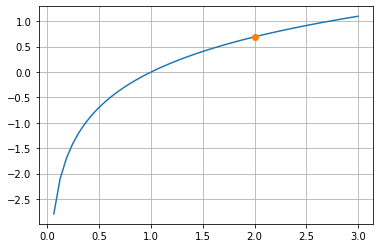

In [13]:
import matplotlib.pyplot as plt
x = np.linspace(0., 3., 50)
y = np.log(x)

plt.plot(x,y)
plt.plot(2, np.log(2), 'o')
plt.grid()

In [14]:
# Example: derivative of ln(x) at x = 2
from math import log

hs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
df_exact = 0.5

for h in hs:
    df_forward = forward_derivative(log, 2.0, h)
    df_backward = backward_derivative(log, 2.0, h)
    df_central = central_derivative(log, 2.0, h)
    print(f'h = {h:7.1e}:')
    print(f'\t* forward : {df_forward:12.6e} (error={df_forward-df_exact:7.1e})')
    print(f'\t* backward: {df_backward:12.6e} (error={df_backward-df_exact:7.1e})')
    print(f'\t* central : {df_central:12.6e} (error={df_central-df_exact:7.1e})')

h = 1.0e-01:
	* forward : 4.879016e-01 (error=-1.2e-02)
	* backward: 5.129329e-01 (error=1.3e-02)
	* central : 5.004173e-01 (error=4.2e-04)
h = 1.0e-02:
	* forward : 4.987542e-01 (error=-1.2e-03)
	* backward: 5.012542e-01 (error=1.3e-03)
	* central : 5.000042e-01 (error=4.2e-06)
h = 1.0e-03:
	* forward : 4.998750e-01 (error=-1.2e-04)
	* backward: 5.001250e-01 (error=1.3e-04)
	* central : 5.000000e-01 (error=4.2e-08)
h = 1.0e-04:
	* forward : 4.999875e-01 (error=-1.2e-05)
	* backward: 5.000125e-01 (error=1.3e-05)
	* central : 5.000000e-01 (error=4.2e-10)
h = 1.0e-05:
	* forward : 4.999988e-01 (error=-1.2e-06)
	* backward: 5.000013e-01 (error=1.3e-06)
	* central : 5.000000e-01 (error=8.8e-12)
h = 1.0e-06:
	* forward : 4.999999e-01 (error=-1.2e-07)
	* backward: 5.000001e-01 (error=1.2e-07)
	* central : 5.000000e-01 (error=1.4e-11)
h = 1.0e-07:
	* forward : 5.000000e-01 (error=-1.3e-08)
	* backward: 5.000000e-01 (error=1.3e-08)
	* central : 5.000000e-01 (error=-2.6e-10)
h = 1.0e-08:
	* for

Have a look at the size of the errors. Importantly, if we decrease the magnitude of $h$ by a factor $n$, then the error of the `forward_derivative` and `backward_derivative` methods also decreases by a factor $n$, but the error of the `central_derivative` method decreases by a factor $n^2$. We say that the `forward_derivative` and `backward_derivative` methods have an error of order $\mathcal{O}(h)$, whereas the `central_derivative` method has an error of order $\mathcal{O}(h^2)$. This is often written as

$$
\begin{aligned}
f'(x) &= \frac{f(x+h) - f(x)}{h} + \mathcal{O}(h)
\\
f'(x) &= \frac{f(x) - f(x-h)}{h} + \mathcal{O}(h)
\\
f'(x) &= \frac{f(x+h) - f(x-h)}{2h} + \mathcal{O}(h^2)
\end{aligned}
$$

For sufficiently small $h$, the `central_derivative` method will therefore tend to be preferable. However, keep in mind that when $h$ becomes too small, numerical round-off errors start to dominate.

### Higher-order derivatives

We can include higher-order terms in the polynomial approximation of the Taylor series expansion. The general form is

$$
f(x+h) = \sum_{n=0}^N \frac{1}{n!} f^{(n)}(x) \cdot h^n + \mathcal{O}(h^{N+1})
$$

We will limit ourselves to the case $N=2$, for which we get the quadratic form

$$
f(x+h) = f(x) + f'(x) \cdot h + \frac{1}{2} f''(x) \cdot h^2 + \mathcal{O}(h^3)
$$

If we apply this to arguments $x-h$, $x$, and $x+h$, and disregard the error term, we obtain a system of three equations

$$
\begin{aligned}
f(x-h) &= f(x) - f'(x) \cdot h + \frac{1}{2} f''(x) \cdot h^2
\\
f(x) &= f(x)
\\
f(x+h) &= f(x) + f'(x) \cdot h + \frac{1}{2} f''(x) \cdot h^2
\end{aligned}
$$

that can be solved using linear algebra techniques to find the solution

$$
\begin{aligned}
f(x) &= f(x)
\\
f'(x) &= \frac{f(x+h) - f(x-h)}{2h}
\\
f''(x) &= \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}
\end{aligned}
$$

We recognise the central difference approximation for $f'(x)$.

**Exercise 4**

Complete the below function `central_derivative2()` that computes the second derivative of a provided function `f`. Determine the order of the error in $f''(x)$ by comparing the numerical value of $f''(x)$ for $f(x)=\ln(x)$ at $x=2$ to its exact analytical value.

In [15]:
def central_derivative2(f, x, h=1e-7):
    """df = central_derivative2(f, x, h).
    Calculates the second-order derivative of the
    function f(x).
    """
    ddf = (f(x+h)-2*f(x)+f(x-h))/(h**2)
    return ddf

In [16]:
# Example: second derivative of ln(x) at x = 2
ddf_exact = -0.25

for h in hs:
    ddf_central = central_derivative2(log, 2.0, h)
    print(f'h = {h:7.1e}:')
    print(f'\t* central : {ddf_central:12.6e} (error={ddf_central-ddf_exact:7.1e})')

h = 1.0e-01:
	* central : -2.503130e-01 (error=-3.1e-04)
h = 1.0e-02:
	* central : -2.500031e-01 (error=-3.1e-06)
h = 1.0e-03:
	* central : -2.500000e-01 (error=-3.1e-08)
h = 1.0e-04:
	* central : -2.500000e-01 (error=1.3e-08)
h = 1.0e-05:
	* central : -2.499989e-01 (error=1.1e-06)
h = 1.0e-06:
	* central : -2.499112e-01 (error=8.9e-05)
h = 1.0e-07:
	* central : -2.553513e-01 (error=-5.4e-03)
h = 1.0e-08:
	* central : 0.000000e+00 (error=2.5e-01)


### Exercises

**Exercise 5**

Determine the bit-representations of `0.1 + 0.2 + 0.3` and `0.6` and confirm that these are not identical. Are `1.0 + 2.0 + 3.0` and `6.0` different as well? Explain your observations.

In [17]:
x = (0.1 + 0.2 + 0.3) 
x == 0.6

# join: list elements
# replace: get rid of the trailing binary encoding '0b'
# rjust: fill up to 8 positions with 0s
# struct.pack python library, !: big endian d: double precision float unpack bytewise
bits = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', x))
bits1 = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', 0.6))
print(bits)
print(bits1)

# no absolute accuracy can be achieved

y = 1.0 + 2.0 +3.0
bits = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', y))
bits1 = ''.join(bin(byte).replace('0b', '').rjust(8, '0') for byte in struct.pack('!d', 6.0))
print(bits)
print(bits1)

# absolute accuracy can be obtained

0011111111100011001100110011001100110011001100110011001100110100
0011111111100011001100110011001100110011001100110011001100110011
0100000000011000000000000000000000000000000000000000000000000000
0100000000011000000000000000000000000000000000000000000000000000


In [18]:
x = 0.1+0.2 +0.3
y = 0.6
1.0+2.0+3.0 == 6.0
print("0.1 + 0.2 + 0.3 = {} , 0.6 = {}".format(x.hex(),y.hex()))
x = 1.0 + 2.0 + 3.0
y = 6.0
print("1.0 + 2.0 + 3.0 = {} , 6.0 = {}".format(x.hex(),y.hex()))

0.1 + 0.2 + 0.3 = 0x1.3333333333334p-1 , 0.6 = 0x1.3333333333333p-1
1.0 + 2.0 + 3.0 = 0x1.8000000000000p+2 , 6.0 = 0x1.8000000000000p+2


**Exercise 6**

Compute the first- and second-order derivatives of the exponential function $g(x) = 2^x$ at $x = 0$ using the following three methods:

* analytically, using symbolic differentiation;

* using your own functions `central_derivative()` and `central_derivative2()`;

* using the function `derivative` of the module `scipy.misc` (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.derivative.html)).

ananlytical solution first derivative: 0.6931471805599453
my solution first derivative: 0.6931471805415867
scipy misc solution first derivative: 0.6931471805415867
ananlytical solution second derivative: 0.4804530139182014
my solution second derivative: 0.48050452505776775
scipy misc solution first derivative: 0.48050452505776775


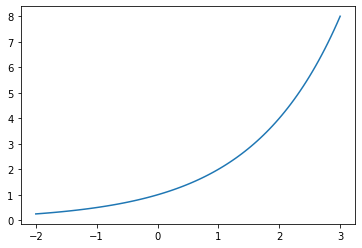

In [19]:
#def my_func(a, x):
#    return a ** x

def my_func(x):
    return 2 ** x
vals = np.linspace(- 2., 3., 100)
plt.plot(vals, my_func(vals))

# analytical solution
print('ananlytical solution first derivative:', 2 ** 0.0 * log(2))

df_central = central_derivative(my_func, 0.0, h = 1e-6)
print('my solution first derivative:', df_central)

# scipy solution
from scipy.misc import derivative
print('scipy misc solution first derivative:', derivative(my_func, 0.0, dx = 1e-6))

# analytical solution
print('ananlytical solution second derivative:', 2 ** 0.0 * (log(2))**2)

df_central2 = central_derivative2(my_func, 0.0, h = 1e-6)
print('my solution second derivative:', df_central2)

# scipy solution
print('scipy misc solution first derivative:', derivative(my_func, 0.0, n = 2, dx = 1e-6))

**Exercise 7**

Compute the derivative of the cosine- and sine-functions at $x = \pi$ using the forward, backward, and central difference approximations. Also, investigate the order of the errors; explain any deviations that you observe in behaviour of the error compared to those in previous examples.

In [20]:
# minimal slope
print(central_derivative(np.cos, np.pi, h = 1e-6))
print(forward_derivative(np.cos, np.pi, h = 1e-6))
print(backward_derivative(np.cos, np.pi, h = 1e-6))
## the central derivative is quite accurate, due to the symmetry of the cosine
## the forward and backward find the same value with different sign, as well due to the periodcity. If you look forward the cos
## is increasing if, you look backwards it is decreasing towards the minimum value at pi.

# maximal slope
print(central_derivative(np.sin, np.pi, h = 1e-6))
print(forward_derivative(np.sin, np.pi, h = 1e-6))
print(backward_derivative(np.sin, np.pi, h = 1e-6))
## the same result is achieved, because for the maximal slop it does not really matter where around the point we look at. The
## error behaves similarly.

0.0
5.000444502911705e-07
-5.000444502911705e-07
-1.0000000001396114
-1.0000000001396114
-1.0000000001396114


**Exercise 8**

The exponential function $f(x) = e^x = \text{exp}(x)$ can be written as a sum

$$
e^x = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4 + \ldots
$$

At the same time, the rational function $g(x) = \frac{1}{1-x}$ can be written as a sum

$$
\frac{1}{1-x} = b_0 + b_1 x + b_2 x^2 + b_3 x^3 + b_4 x^4 + \ldots
$$

Find the values of the coefficients $a_0, a_1, \ldots, a_4$ and $b_0, b_1, \ldots, b_4$ by calculating the $n$-th derivatives $f^{(n)}(x)$ and $g^{(n)}(x)$ and inserting these in the Taylor series expansion. Can you discern a pattern in the values of these coefficients?

Next, plot the function $f(x)$ along with the Taylor approximations $a_0 + \ldots + a_k x^k$ for several increasing values of $k$. Do the same for $g(x)$ in a separate plot. Do the approximations converge towards the original functions everywhere?

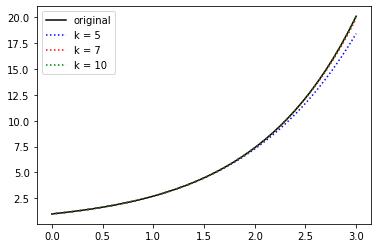

In [21]:
# input: function e^x, number of coeffiecients (= order of taylor polynom, how often we need to form derivative), start/center of taylor series
from scipy.misc import derivative
import numpy as np
import math

# define the two functions
def my_e(x):
    return np.e ** x

def my_ratio(x):
    return x / (1 - x)

# get taylor approximation
def taylor_approx(func, start, order_d, dx, x):
    
    # get derivative
    order_points = 0 # derivative scipy parameter
    if order_d % 2 == 0:
        order_points = order_d + 3
    else:
        order_points = order_d + 2
    
    # make container for the coefficients
    coef = []
    
    # derivative and evluation of it at the start value
    for i in range(0, order_d + 1):
        coef.append(derivative(func, x0 = start, dx = dx, n = i, order = order_points))
    #print(coef)
    
    # form taylor polynom
    y = []
    for xi in x:
        y.append(sum([(1/math.factorial(i)) * coef[i] * (xi - start) ** i for i in range(0, len(coef))])) # here (xi - start)
    return y

# make new x values
x = np.linspace(0., 3., 41)

# caluclate the y values with several different number of derivatives involved:
# k = 5
yi = taylor_approx(my_e, 0, 5, np.pi/30, x)

# k = 7
y7 = taylor_approx(my_e, 0, 7, np.pi/30, x)
# k = 10
y10 = taylor_approx(my_e, 0, 10, np.pi/30, x)


plt.plot(x, np.e **x, 'k', label = 'original')
plt.plot(x, yi, ':b', label = 'k = 5')
plt.plot(x, y7, ':r', label = 'k = 7')
plt.plot(x, y10, ':g', label = 'k = 10')
plt.legend()
plt.show()

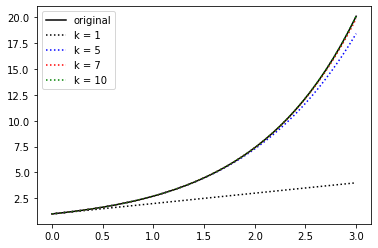

In [63]:
# input: function e^x, number of coeffiecients (= order of taylor polynom, how often we need to form derivative), start/center of taylor series
from scipy.misc import derivative
import numpy as np
import math

# define the two functions
def my_e(x):
    return np.e ** x

def my_ratio(x):
    return 1 / (1 - x)

# get taylor approximation
def taylor_approx(func, start, order_d, dx, x):
    
    # get derivative
    order_points = 0 # derivative scipy parameter
    if order_d % 2 == 0:
        order_points = order_d + 3
    else:
        order_points = order_d + 2
    
    # make container for the coefficients
    coef = []
    b=[]
    # derivative and evluation of it at the start value
    for i in range(0, order_d + 1):
        coef.append(derivative(func, x0 = start, dx = dx, n = i, order = 2*i+1)) # order points is fixed for running one definite talor series
        b.append(order_points)
    #print(coef)
    
    # form taylor polynom
    y = []
    for xi in x:
        y.append(sum([(1/math.factorial(i)) * coef[i] * (xi) ** i for i in range(0, len(coef))]))
    return y

# make new x values
x = np.linspace(0., 3., 41)

# caluclate the y values with several different number of derivatives involved:
y1 = taylor_approx(my_e, 0, 1, np.pi/30, x)
# k = 5
yi = taylor_approx(my_e, 0, 5, np.pi/30, x)

# k = 7
y7 = taylor_approx(my_e, 0, 7, np.pi/30, x)
# k = 10
y10 = taylor_approx(my_e, 0, 10, np.pi/30, x)


plt.plot(x, np.e **x, 'k', label = 'original')
plt.plot(x, y1, ':k', label = 'k = 1')
plt.plot(x, yi, ':b', label = 'k = 5')
plt.plot(x, y7, ':r', label = 'k = 7')
plt.plot(x, y10, ':g', label = 'k = 10')
plt.legend()
plt.show()

[1.0, 1.0001096742982576, 1.9999999037375733, 5.999996459292446, 23.999999911022897, 120.00000289375454]
[1.0, 1.0001096742982576, 1.9999999037375733, 5.999996459292446, 23.999999911022897, 120.00000289375454, 719.9922802493071, 5040.292676669462]
[1.0000000100000002, 1.0101010305070912, 1.9991583090984528, 5.966256203459473, 24.02690023001703, 121.63762905525033, 714.0408861576703, 4380.718498232098, 50635.450032254405, 4017163.0225980924, 2039837487459385.2]


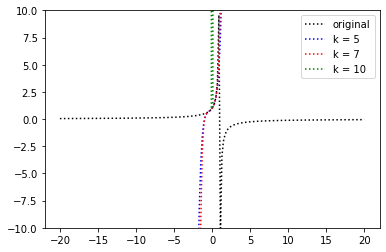

In [62]:
# make new x values
x = np.linspace(-20., 20., 202)
# caluclate the y values with several different number of derivatives involved:
# k = 5
yi = taylor_approx(my_ratio, 0, 5, np.pi/300, x)

# k = 7
y7 = taylor_approx(my_ratio, 0, 7, np.pi/300, x)
# k = 10
y10 = taylor_approx(my_ratio, 1e-8, 10, 1e-1, x)

plt.plot(x, my_ratio(x), ':k', label = 'original')
plt.plot(x, yi, ':b', label = 'k = 5')
plt.plot(x, y7, ':r', label = 'k = 7')
plt.plot(x, y10, ':g', label = 'k = 10')
plt.legend()
plt.ylim(-10., 10.)
plt.show()

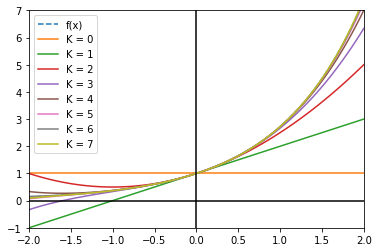

[1, 3, 5, 7, 9, 11, 13, 15]


In [31]:
import matplotlib.pyplot as plt
from math import factorial
import numpy as np
from scipy.misc import derivative

f = lambda x: np.exp(x)
fac = lambda x:factorial(x)
a = [];b=[]
x = np.linspace(-2,+2,101)
plt.plot(x,f(x),"--",label="f(x)")
k = 8
for i in range(k):
    b.append(2*i+1)
    a.append(derivative(f,0,n=i,dx=1e-2,order = 2*i+1)/fac(i))
    t = lambda x: sum(a[j]*x**j for j in range(len(a)))
    plt.plot(x,t(x),label = "K = {}".format(i))
plt.axhline(0.0,color="black")
plt.axvline(0.0,color="black")
plt.ylim(-1,7);plt.xlim(-2,2)
plt.legend()    
plt.show()
print(b)


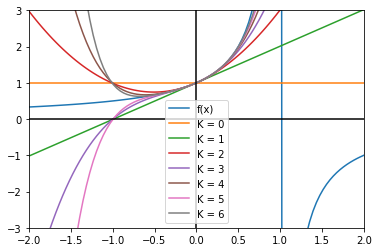

[1.0, 1.0101010101010104, 1.9991582491582252, 5.9662559662558, 24.026899026887698, 121.63762163781561, 714.0408367892721]


In [37]:
f = lambda x: 1/(1-x)
fac = lambda x:factorial(x)
a = []
b=[]
x = np.linspace(-2,2,100)
plt.plot(x,f(x),label="f(x)")
k = 7
for i in range(k):
    b.append(derivative(f,0,n=i,dx=1e-1,order = 2*i+1))
    a.append(derivative(f,0,n=i,dx=1e-1,order = 2*i+1)/fac(i))
    t = lambda x: sum(a[j]*x**j for j in range(len(a)))
    plt.plot(x,t(x),label = "K = {}".format(i))
plt.axhline(0.0,color="black")
plt.axvline(0.0,color="black")
plt.ylim(-3,3);plt.xlim(-2,2)
plt.legend(loc="lower center") 
plt.show()
print(b)

***